In [29]:
import pandas as pd
import os
import string
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

datapath = './enron-event-history-all.csv'

In [30]:
def readcleanandprocess(datapath):
    df = pd.read_csv(datapath, header=None)                       # csv has no headers
    df.rename(columns={0: 'time', 1: 'message_id', 2:'sender', 3:'recipients',
                      4:'topic', 5:'mode'}, inplace=True)
    df.drop(['topic', 'mode'], axis = 1, inplace = True)          # drop useless columns
    df['time'] = pd.to_datetime(df['time'], unit='ms')            # convert to datetime
    return df
    
df = readcleanandprocess(datapath)
df.head()

,time,message_id,sender,recipients
0,1998-05-27 22:31:00,<GKNWYZTKAVMKBCTMA3ZZSQIBITG5OD1KA@zlsvr22>,Christopher Behney,Toni P Schulenburg|mary hain
1,1998-10-30 23:43:00,<N5QXQ4CHS04FBSJO3TALWRBXATDTIWZ0B@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
2,1998-10-30 23:56:00,<FEJ0YLF5MHTTF2QHNWMRUODCCHDCPUA5A@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
3,1998-10-31 00:02:00,<NFC21LWTHYCKD4JV1IQMLSQ4JX2WY1JCB@zlsvr22>,mark legal taylor,shari stack
4,1998-10-31 01:06:00,<LAGJQ1MQZ2HX3APYD2TBODXUA4XF04UOA@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com


### Check for NaN values

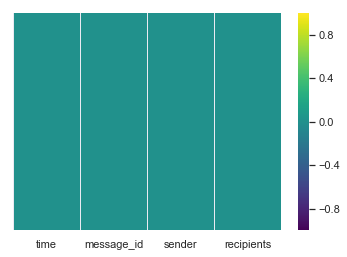

In [31]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis'
           ,vmax=1.0, vmin=-1.0 )

In [32]:
print("We only have "+str(len(df[df.isnull().any(axis=1)])/len(df))+"% NaN values so we drop those rows")
df = df.dropna() 

We only have 0.00034025013245451584% NaN values so we drop those rows


## 1 

### 1.1 Get all unique users (from senders as well as recipients)

In [33]:
def calculateTotalPeople(df):
    senderlist = df['sender'].unique()

    df2 = pd.DataFrame()
    df2['time'] = df['time']
    df2['sender'] = df['sender']
    df2['recipients'] = df['recipients']

    def stringtolist(recepientstring):
        return recepientstring.split("|")

    df2['RecipientList'] = df2.apply(lambda row: stringtolist(row['recipients']), axis=1)    # split on '|' to get list

    recipients = df2['RecipientList'].apply(pd.Series).stack()                # get all elements from all lists in a list
    recipients = recipients.unique()                                          # keep each only once
    people = list(set(list(recipients)+list(senderlist)))                # convert to set to drop duplicates, then list 
    people.remove('')                                                    # remove the empty string from the data
    return df2, people

df2, people = calculateTotalPeople(df)
print("There are "+str(len(people))+" unique 'people' in the dataset")

There are 36445 unique 'people' in the dataset


In [34]:
df2.head()

,time,sender,recipients,RecipientList
0,1998-05-27 22:31:00,Christopher Behney,Toni P Schulenburg|mary hain,"[Toni P Schulenburg, mary hain]"
1,1998-10-30 23:43:00,mark legal taylor,Marc.R.Cutler@BankAmerica.com,[Marc.R.Cutler@BankAmerica.com]
2,1998-10-30 23:56:00,mark legal taylor,Marc.R.Cutler@BankAmerica.com,[Marc.R.Cutler@BankAmerica.com]
3,1998-10-31 00:02:00,mark legal taylor,shari stack,[shari stack]
4,1998-10-31 01:06:00,mark legal taylor,Marc.R.Cutler@BankAmerica.com,[Marc.R.Cutler@BankAmerica.com]


### 1.2 Calculate Senders

In [35]:
def calculateSenders(df):
    opsdict = {'timesAsSender':'count'}                                    
    df['timesAsSender'] = 0
    dfsenders = df.groupby('sender').agg(opsdict) 
    df.drop(['timesAsSender'], inplace=True, axis=1)
    return dfsenders
    
dfsenders = calculateSenders(df)
dfsenders.head()

,timesAsSender
sender,
"""Association.of.Pat""@aplf.org]",1
"""Merriam-Webster's Word of the Day"" <MW-WOD@LISTSERV.WEBSTER.M-W.COM>@ENRON",55
"""specialistdirectories@euromoneyplc.com"" <specialistdirectories@euromoneyplc.com>@ENRON",1
*MISC Exchange Customer Activities\tcustomeractivities@gulfsouthpl.com@ENRON,1
.,3


### 1.3 Calculate Recipients

In [36]:
def calculateRecipients(df2):
    def splitDataFrameList(df,target_column,separator):                 # explode list of recipients to one per row
        row_accumulator = []
        def splitListToRows(row, separator):
            for s in row[target_column]:
                new_row = row.to_dict()
                new_row[target_column] = s
                row_accumulator.append(new_row)

        df.apply(splitListToRows, axis=1, args = (separator, ))
        new_df = pd.DataFrame(row_accumulator)
        return new_df


    df3 = splitDataFrameList(df2, 'RecipientList', ',')               # we are going to need this for part3          
    df3['timesAsRecipient'] = df3['RecipientList']

    opsdict = {'timesAsRecipient':'count'}          

    dfrecipients = df3.groupby('RecipientList').agg(opsdict) 
    dfrecipients.reset_index(inplace=True)
    dfrecipients.rename(columns={'RecipientList': 'recipient'}, inplace=True)
    dfrecipients = dfrecipients.iloc[1:]                                # drop 1st row - it is useless in our case
    return dfrecipients, df3
    
dfrecipients, df3 = calculateRecipients(df2)
dfrecipients.head(10)

,recipient,timesAsRecipient
1,- *Joan.Veselack@enron.com,1
2,"- *Porter, Jeffrey",2
3,"- *Stiles, Marianne",1
4,- *murex@manado.wasantara.net.id,1
5,"""""mossyuk""@hotmail.com""",1
6,""")bob.m.hall""@enron.com",1
7,"""Burgess Rountree""@smtp.onr.com",1
8,"""Chris Edmonds""@carvey.adgrafix.com",1
9,"""Chris Higgs""@smtp.onr.com",1
10,"""Cianf""@ENRON>",1


In [37]:
df3.head()

,RecipientList,recipients,sender,time,timesAsRecipient
0,Toni P Schulenburg,Toni P Schulenburg|mary hain,Christopher Behney,1998-05-27 22:31:00,Toni P Schulenburg
1,mary hain,Toni P Schulenburg|mary hain,Christopher Behney,1998-05-27 22:31:00,mary hain
2,Marc.R.Cutler@BankAmerica.com,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-10-30 23:43:00,Marc.R.Cutler@BankAmerica.com
3,Marc.R.Cutler@BankAmerica.com,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-10-30 23:56:00,Marc.R.Cutler@BankAmerica.com
4,shari stack,shari stack,mark legal taylor,1998-10-31 00:02:00,shari stack


### 1.4 Export a dataframe: person - timesAsSender - timesAsRecipient

In [38]:
def exportToCsv(people, dfsenders, dfrecipients):
    df_total = pd.DataFrame()
    df_total['person'] = people

    lol = pd.merge(df_total, dfsenders, left_on='person', right_on='sender', how="outer")
    lol.timesAsSender.fillna(0, inplace=True)

    lol2 = pd.merge(df_total, dfrecipients, left_on='person', right_on='recipient', how="outer")
    lol2.timesAsRecipient.fillna(0, inplace=True)

    df_total['timesAsSender'] = lol['timesAsSender'].astype(int)
    df_total['timesAsRecipient'] = lol2['timesAsRecipient'].astype(int)
    df_total = df_total.sort_values(by=['timesAsSender'], ascending=False)
    df_total.head()

    output1path = './summarydata.csv'

    df_total.to_csv(output1path)
    #lol.head()
    return df_total
    
df_total = exportToCsv(people, dfsenders, dfrecipients)

## 2

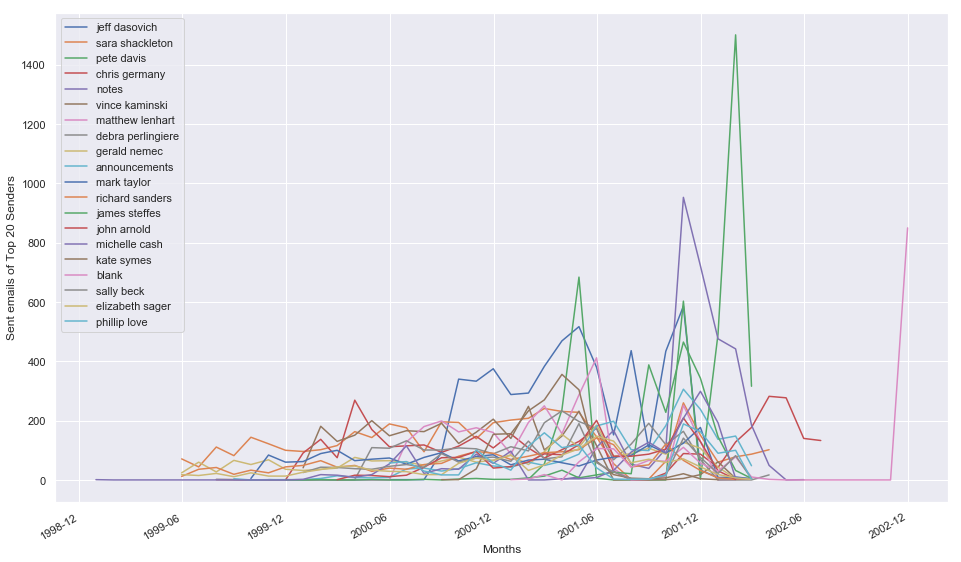

In [74]:
def exportLineChart(df_total, df):
    bestsenders = list(df_total.head(20)['person'])             # Get 20 top senders
    outputpath = './top_senders_plot'
    count=0
    plt.figure(figsize=(16,10))
    sns.set(style="darkgrid")
    #sns.set_context("paper", rc={"font.size":12,"axes.titlesize":25,"axes.labelsize":12})

    if not os.path.exists(outputpath):
        os.mkdir(outputpath)

    for senderperson in bestsenders:
        count = count+1
        tempdf = df[df['sender']==senderperson][['time','message_id']]
        tempdf.set_index('time',inplace=True)

        agg = tempdf.resample('M').count()                  # resample by month   
        agg.reset_index(inplace=True)                       # needed for the TS plot

        ax = sns.lineplot(x="time", y="message_id", label=str(senderperson), data=agg)

        #ax.xaxis.set_major_locator(mdates.MONTHS_PER_YEAR)

        ax.set(xlabel='Months', ylabel='Sent emails of Top 20 Senders')
        plt.gcf().autofmt_xdate()                           # fix tick labels


    fig = ax.get_figure()                               
    fig.savefig(outputpath+'/senders.png')                  # save figure to .png
    
exportLineChart(df_total, df)

## 3 

In [47]:
df3.head(10)

,RecipientList,sender,time
0,Toni P Schulenburg,Christopher Behney,1998-05-27 22:31:00
1,mary hain,Christopher Behney,1998-05-27 22:31:00
2,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-10-30 23:43:00
3,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-10-30 23:56:00
4,shari stack,mark legal taylor,1998-10-31 00:02:00
5,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-10-31 01:06:00
6,yao apasu,mark legal taylor,1998-11-03 03:32:00
7,brent hendry,yao apasu,1998-11-03 19:12:00
8,mark legal taylor,yao apasu,1998-11-03 19:12:00
9,Marc.R.Cutler@BankAmerica.com,mark legal taylor,1998-11-04 18:31:00


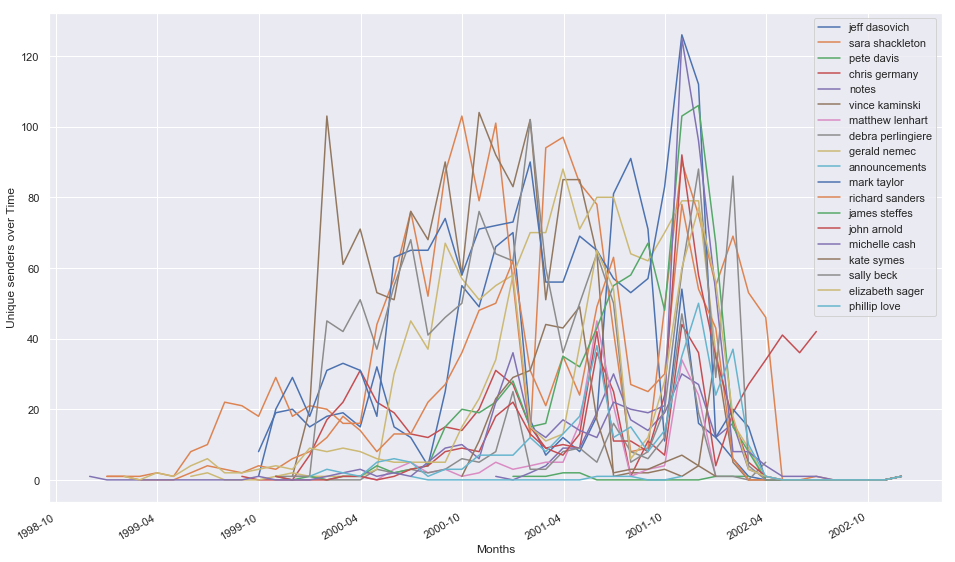

In [75]:
def exportLineChart2(df3, df_total):
    bestsenders = list(df_total.head(20)['person'])             # Get 20 top senders
    plt.figure(figsize=(16,10))
    sns.set(style="darkgrid")
    outputpath2 = './unique_senders_plot'
    if not os.path.exists(outputpath2):
        os.mkdir(outputpath2)
        
    for person in bestsenders:
        tempdf = df3[df3['RecipientList']==person][['time','sender']]
        #print(tempdf)
        #tempdf.drop(['RecipientList'], axis = 1, inplace=True)
        tempdf.set_index('time',inplace=True)
        agg = tempdf.resample('M').nunique()
        agg.reset_index(inplace=True)                       # needed for the TS plot
        
        ax = sns.lineplot(x="time", y="sender", label=str(person), data=agg)

        #ax.xaxis.set_major_locator(mdates.MONTHS_PER_YEAR)

        ax.set(xlabel='Months', ylabel='Unique senders over Time')
        plt.gcf().autofmt_xdate()                           # fix tick labels


    fig = ax.get_figure()                               
    fig.savefig(outputpath2+'/recievers.png')                  # save figure to .png
    
    
exportLineChart2(df3, df_total)   

In [76]:
df3[df3['sender']=='jeff dasovich'].head()

,RecipientList,sender,time
5210,steve montovano,jeff dasovich,1999-10-28 17:08:00
5211,james steffes,jeff dasovich,1999-10-28 17:08:00
5212,richard shapiro,jeff dasovich,1999-10-28 17:08:00
5213,susan covino,jeff dasovich,1999-10-28 17:08:00
5214,susan mara,jeff dasovich,1999-10-28 17:08:00


In [94]:
lol = df3[df3['RecipientList']=='pete davis'].drop(['RecipientList'], axis = 1)
lol.set_index('time',inplace=True)
lol.head()
aggtemp = lol.resample('M').nunique() 
aggtemp

,sender
time,
2000-12-31,1
2001-01-31,1
2001-02-28,1
2001-03-31,2
2001-04-30,2
2001-05-31,0
2001-06-30,0
2001-07-31,0
2001-08-31,0


In [97]:
df.head()

,time,message_id,sender,recipients
0,1998-05-27 22:31:00,<GKNWYZTKAVMKBCTMA3ZZSQIBITG5OD1KA@zlsvr22>,Christopher Behney,Toni P Schulenburg|mary hain
1,1998-10-30 23:43:00,<N5QXQ4CHS04FBSJO3TALWRBXATDTIWZ0B@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
2,1998-10-30 23:56:00,<FEJ0YLF5MHTTF2QHNWMRUODCCHDCPUA5A@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
3,1998-10-31 00:02:00,<NFC21LWTHYCKD4JV1IQMLSQ4JX2WY1JCB@zlsvr22>,mark legal taylor,shari stack
4,1998-10-31 01:06:00,<LAGJQ1MQZ2HX3APYD2TBODXUA4XF04UOA@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com


In [98]:
lol2 = df[df['sender']=='pete davis'][['time','message_id']]
lol2.set_index('time',inplace=True)
#lol2.head()
aggtemp2 = lol.resample('M').count() 
aggtemp2

,sender
time,
2000-12-31,1
2001-01-31,1
2001-02-28,1
2001-03-31,2
2001-04-30,2
2001-05-31,0
2001-06-30,0
2001-07-31,0
2001-08-31,0


jeff dasovich
sara shackleton
pete davis
         time  emails_sent  unique_senders       ratio
0  2001-01-31            2               1    1.500000
1  2001-02-28           54               1   27.500000
2  2001-03-31          237               2   79.333333
3  2001-04-30          684               2  228.333333
4  2001-05-31            6               0    7.000000
5  2001-06-30            0               0    1.000000
6  2001-07-31            0               0    1.000000
7  2001-08-31            0               0    1.000000
8  2001-09-30            0               0    1.000000
9  2001-10-31          603               0  604.000000
10 2001-11-30            3               0    4.000000
11 2001-12-31          492               1  246.500000
12 2002-01-31         1501               1  751.000000
13 2002-02-28          316               1  158.500000
chris germany
notes
vince kaminski
matthew lenhart
debra perlingiere
gerald nemec
announcements
mark taylor
richard sanders
james stef

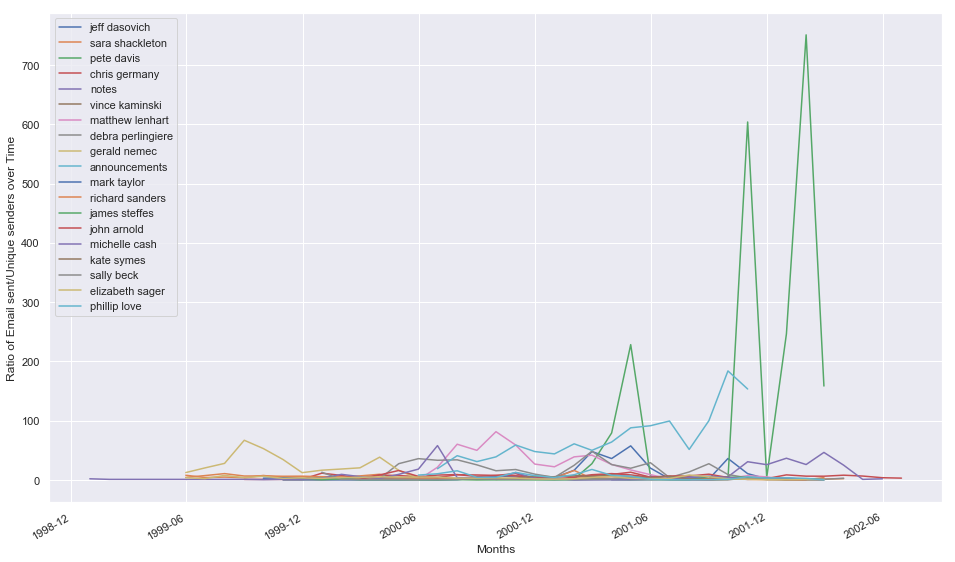

In [100]:
def exportLineChart3(df, df3, df_total):
    bestsenders = list(df_total.head(20)['person'])             # Get 20 top senders
    plt.figure(figsize=(16,10))
    sns.set(style="darkgrid")
    outputpath3 = './ratio_plot'
    if not os.path.exists(outputpath3):
        os.mkdir(outputpath3)
        
    for person in bestsenders:
        print(str(person))
        #tempdf = df3[df3['RecipientList']==person]
        
        tempdf1 = df[df['sender']==person][['time','message_id']]
        tempdf2 = df3[df3['RecipientList']==person].drop(['RecipientList'], axis = 1)
        
        tempdf1.set_index('time',inplace=True)
        tempdf2.set_index('time',inplace=True)
        
        agg1 = tempdf1.resample('M').count()          # how many emails they sent per month
        agg1.reset_index(inplace=True)
        agg2 = tempdf2.resample('M').nunique()        # how many unique people sent them emails per month
        agg2.reset_index(inplace=True)
        
        final = pd.merge(agg1, agg2, on='time')
        #print("agg1 is "+str(len(agg1))+", agg2 is "+str(len(agg2))+" and final is "+str(len(final)))
        final.rename(columns={'message_id': 'emails_sent', 'sender': 'unique_senders'}, inplace=True)
        
        final['ratio'] = (final['emails_sent']+1)/(1+final['unique_senders'])
        
#         if str(person)=='pete davis':
#             print(final)
        ax = sns.lineplot(x="time", y="ratio", label=str(person), data=final)

        #ax.xaxis.set_major_locator(mdates.MONTHS_PER_YEAR)

        ax.set(xlabel='Months', ylabel='Ratio of Email sent/Unique senders over Time')
        plt.gcf().autofmt_xdate()                           # fix tick labels


    fig = ax.get_figure()                               
    fig.savefig(outputpath3+'/ratio_plot.png')                  # save figure to .png
    
    
exportLineChart3(df, df3, df_total)   

In [55]:
# def exportBarChart(df_total, df3):
#     df3.drop(['timesAsRecipient', 'recipients'], axis = 1, inplace = True) 
#     #df3.head(10)   
#     bestsenders = list(df_total.head(20)['person'])             # Get 20 top senders
#     plt.figure(figsize=(16,10))
#     sns.set(style="darkgrid")
#     outputpath2 = './unique_senders_plot'
#     if not os.path.exists(outputpath2):
#         os.mkdir(outputpath2)

#     def getuniquesenders(person):
#         return len(df3[df3['RecipientList']==person]['sender'].unique())

#     df_final = pd.DataFrame()
#     df_final['person'] = bestsenders    
#     df_final['unique_senders'] = df_final.apply(lambda row: getuniquesenders(row['person']), axis=1)

#     ax = sns.barplot(x='person', y='unique_senders', data=df_final)
#     ax.set(xlabel='People', ylabel='Unique Senders per person')
#     plt.gcf().autofmt_xdate()
#     fig = ax.get_figure()                               
#     fig.savefig(outputpath2+'/unique_senders.png')                  # save figure to .png


# exportBarChart(df_total, df3)